#Importação dos pacotes necessários e etapas iniciais

In [ ]:
# Importação dos pacotes
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession
import gradio as gr
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Cria a SparkSession - usada quando se trabalha com Dataframes no Spark
spSession = SparkSession.builder \
    .appName("ALS Example") \
    .master("local[*]") \
    .getOrCreate()

# Obtém o SparkContext a partir da SparkSession
sc = spark.sparkContext  # Cria o SparkContext, que gerencia os recursos e executa operações com RDDs

# Agora você pode carregar o arquivo com sc.textFile
ratingsRDD = sc.textFile("user-item.txt")  # Carrega o arquivo como um RDD, cada linha é um elemento
ratingsRDD.collect()  # Retorna todos os elementos do RDD como uma lista (útil para inspeção em pequenos conjuntos)


['1001,9001,10',
 '1001,9002,1',
 '1001,9003,9',
 '1002,9001,3',
 '1002,9002,5',
 '1002,9003,1',
 '1002,9004,10',
 '1003,9001,2',
 '1003,9002,6',
 '1003,9003,2',
 '1003,9004,9',
 '1003,9005,10',
 '1003,9006,8',
 '1003,9007,9',
 '1004,9001,9',
 '1004,9002,2',
 '1004,9003,8',
 '1004,9004,3',
 '1004,9010,10',
 '1004,9011,9',
 '1004,9012,8',
 '1005,9001,8',
 '1005,9002,3',
 '1005,9003,7',
 '1005,9004,1',
 '1005,9010,9',
 '1005,9011,10',
 '1005,9012,9',
 '1005,9013,8',
 '1005,9014,1',
 '1005,9015,1',
 '1006,9001,7',
 '1006,9002,4',
 '1006,9003,8',
 '1006,9004,1',
 '1006,9010,7',
 '1006,9011,6',
 '1006,9012,9']

#Análise Exploratória

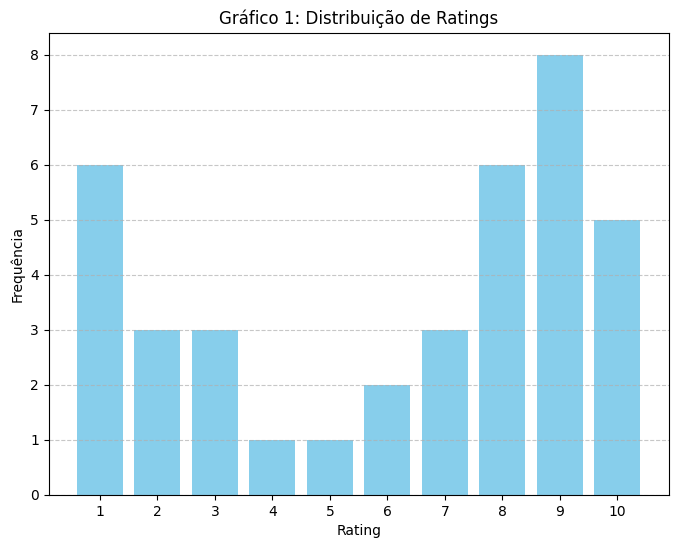

In [ ]:
#Distribuição de Ratings

# Mapeia as linhas para uma estrutura adequada para o DataFrame
ratings_data = ratingsRDD.map(lambda line: line.split(',')).map(lambda parts: (int(parts[0]), int(parts[1]), float(parts[2]))).toDF(["userId", "movieId", "rating"])

# Conta a frequência de cada rating
rating_counts = ratings_data.groupBy("rating").count().orderBy("rating").toPandas()

# Cria o gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(rating_counts["rating"], rating_counts["count"], color='skyblue')
plt.xlabel("Rating")
plt.ylabel("Frequência")
plt.title("Gráfico 1: Distribuição de Ratings")
plt.xticks(rating_counts["rating"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

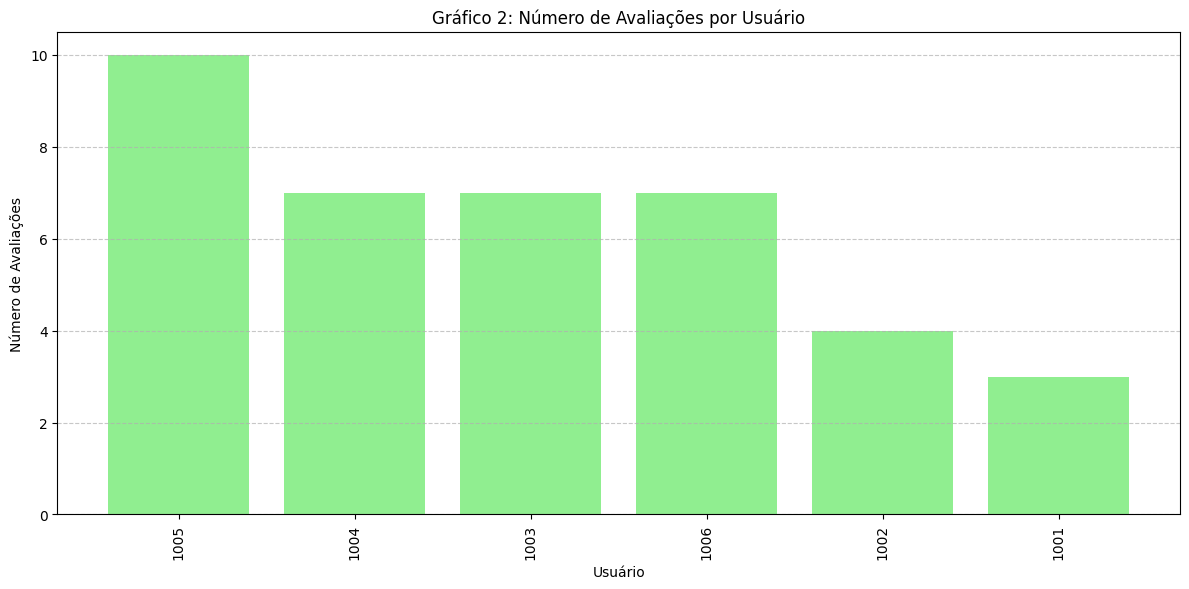

In [ ]:
#Número de avaliações por usuário

# Conta o número de avaliações por usuário
user_ratings_count = ratings_data.groupBy("userId").count().toPandas()

# Ordena os usuários pelo número de avaliações (opcional)
user_ratings_count = user_ratings_count.sort_values(by="count", ascending=False)

# Cria o gráfico de barras para o número de avaliações por usuário
plt.figure(figsize=(12, 6))
plt.bar(user_ratings_count["userId"].astype(str), user_ratings_count["count"], color='lightgreen')
plt.xlabel("Usuário")
plt.ylabel("Número de Avaliações")
plt.title("Gráfico 2: Número de Avaliações por Usuário")
# Limita a quantidade de rótulos no eixo x para não sobrecarregar o gráfico em datasets grandes
if len(user_ratings_count) > 20:
    plt.xticks([]) # Não mostra rótulos se houver muitos usuários
else:
    plt.xticks(rotation=90) # Rotaciona rótulos se houver poucos usuários

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()


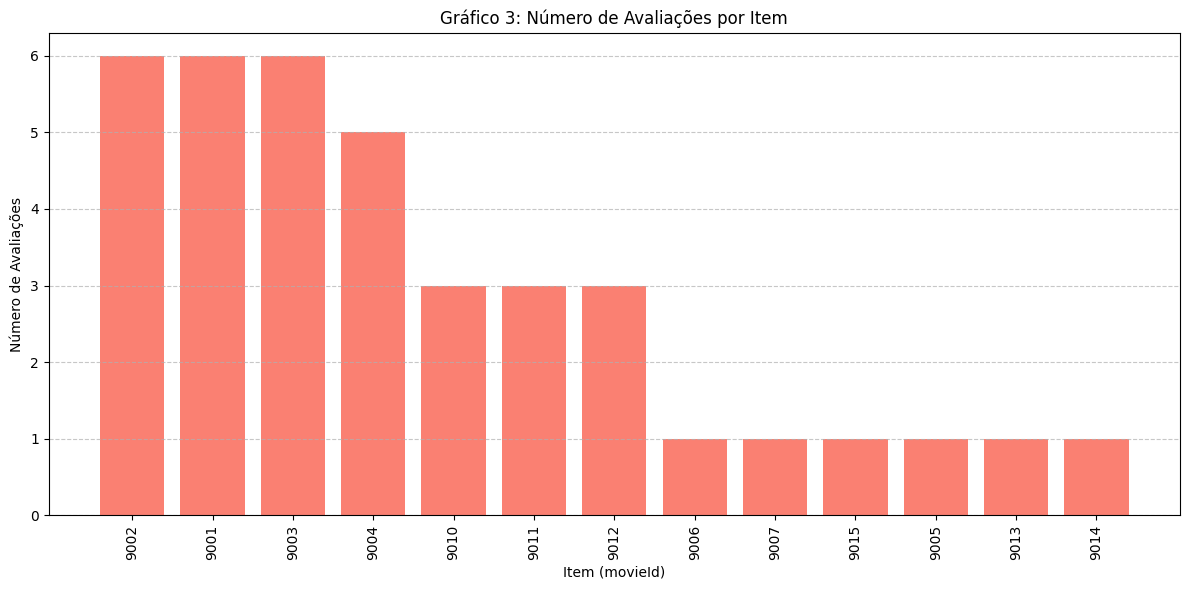

In [ ]:
#Número de avaliações por item

# Conta o número de avaliações por item (movieId)
item_ratings_count = ratings_data.groupBy("movieId").count().toPandas()

# Ordena os itens pelo número de avaliações (opcional)
item_ratings_count = item_ratings_count.sort_values(by="count", ascending=False)

# Cria o gráfico de barras para o número de avaliações por item
plt.figure(figsize=(12, 6))
plt.bar(item_ratings_count["movieId"].astype(str), item_ratings_count["count"], color='salmon')
plt.xlabel("Item (movieId)")
plt.ylabel("Número de Avaliações")
plt.title("Gráfico 3: Número de Avaliações por Item")
# Limita a quantidade de rótulos no eixo x para não sobrecarregar o gráfico em datasets grandes
if len(item_ratings_count) > 20:
    plt.xticks([]) # Não mostra rótulos se houver muitos itens
else:
    plt.xticks(rotation=90) # Rotaciona rótulos se houver poucos itens

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

#Pré-processamento dos dados

In [ ]:
# Convertendo as strings
ratingsRDD2 = ratingsRDD.map(lambda l: l.split(',')).map(lambda l:(int(l[0]), int(l[1]), float(l[2])))
# Divide a linha por vírgula e transforma em (user, item, rating) como inteiros e float

In [ ]:
# # Cria um DataFrame a partir do RDD, nomeando as colunas para facilitar análises e modelagem
ratingsDF = spSession.createDataFrame(ratingsRDD2, ["user", "item", "rating"])

In [ ]:
ratingsDF #Visualização do DataFrame criado

DataFrame[user: bigint, item: bigint, rating: double]

#Algoritmo ALS - Sistema de Recomendação

In [ ]:
# Construindo o modelo
# ALS = Alternating Least Squares --> Algoritmo para sistema de recomendação, que otimiza a loss function
# e funciona muito bem em ambientes paralelizados
als = ALS(rank = 10, maxIter = 6)
modelo = als.fit(ratingsDF)

In [ ]:
# Visualizando o Affinity Score pelo ID
modelo.userFactors.orderBy("id").collect()

[Row(id=1001, features=[-0.07659713178873062, 0.30633631348609924, -1.5256153345108032, 0.41356340050697327, -0.5193612575531006, 0.17305360734462738, -0.3382662534713745, 0.31354209780693054, -0.5895534157752991, -0.02181447297334671]),
 Row(id=1002, features=[0.7885196208953857, 0.008316513150930405, -0.04025169834494591, 0.07555210590362549, 0.3296516239643097, -0.02861100435256958, -1.2735676765441895, -1.0957307815551758, 0.5774515867233276, 0.3626152276992798]),
 Row(id=1003, features=[0.3300241231918335, 0.3839123547077179, 0.169003427028656, -0.1815783828496933, 0.8399822115898132, -0.08863575756549835, -1.0982630252838135, -0.7568644285202026, 0.27461913228034973, 0.4576881229877472]),
 Row(id=1004, features=[0.17586272954940796, 0.32581624388694763, -1.1818523406982422, 0.27801328897476196, -0.4260644316673279, 0.3187316358089447, -0.6743565201759338, -0.31310251355171204, -0.5677353739738464, 0.020234793424606323]),
 Row(id=1005, features=[-0.007205585017800331, 0.2369380891

In [ ]:
# Criando um dataset de teste com usuários e items para rating
testeDF = spSession.createDataFrame([(1001,9004),(1001,9005),(1001,9010)], ["user", "item"])

In [ ]:
# Previsões
# Quanto maior o Affinity Score, maior a probabilidade do usuário aceitar uma recomendação
previsoes = (modelo.transform(testeDF).collect())
previsoes

[Row(user=1001, item=9004, prediction=-0.5887318253517151),
 Row(user=1001, item=9005, prediction=-2.5206472873687744),
 Row(user=1001, item=9010, prediction=11.300518035888672)]

#Aplicação Web do Sistema de Recomendações usando Gradio

In [ ]:
# Função para fazer a recomendação
def fazer_recomendacao(user_id):
    """
    Faz recomendações de itens para um determinado user_id.
    """
    # Cria um DataFrame de teste para o usuário especificado
    user_test_df = spSession.createDataFrame([(int(user_id), item) for item in ratingsDF.select('item').distinct().rdd.flatMap(lambda x: x).collect()], ["user", "item"])

    # Faz as previsões para o usuário
    previsoes = modelo.transform(user_test_df)

    # Ordena as previsões por rating previsto e seleciona os top N
    top_n_recomendacoes = previsoes.orderBy("prediction", ascending=False)

    # Retorna as recomendações como uma lista de tuplas (item, rating previsto)
    return [(row.item, row.prediction) for row in top_n_recomendacoes.collect()]

# Cria a interface Gradio
iface = gr.Interface(
    fn=fazer_recomendacao,
    inputs=gr.Textbox(label="Digite o ID do Usuário:"),
    outputs=gr.Dataframe(headers=["Item ID", "Rating Previsto"], label="Recomendações:"),
    title="Sistema de Recomendação com PySpark",
    description="Digite o ID de um usuário para obter recomendações de itens."
)

# Lança a interface
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6eb647614bed0badeb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
